In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

## Dependencies

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import benchmark, GenericOuterHook

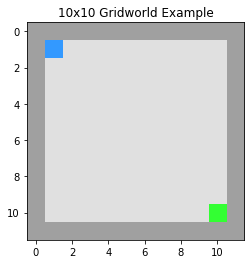

In [3]:
name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=1000,
    override=True
)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = gridworld.reset()

img_a = gridworld.unwrapped.get_image()
gridworld.close()

plt.imshow(img_a)
plt.title("10x10 Gridworld Example")

plt.show()

In [11]:
AgentShelve.get_keyword_args('TabularQET')

<Signature (observation_shape: 'typing.Tuple[int, int]', n_actions: 'int', lr: 'float' = 0.5, decay: 'float' = 0.9, n_steps: 'int' = None, epsilon: 'float' = 0.1, discount: 'float' = 0.95, replace: 'bool' = False, decay_lr: 'float' = -0.5, eta: 'float' = 0.0, beta: 'float' = 0.5, sarsa: 'bool' = False, q_init: 'float' = 0.0) -> 'None'>

In [82]:
QET_args = {  # Use replacing eligibility traces
    'QLearning = QET(0, 1)': dict(eta=1.0, beta=1.0, decay=0.0, replace=True, decay_lr=0.0),
    'Q(Lambda) = QET(0.9, 1)': dict(eta=1.0, beta=1.0, decay=0.9, replace=True, decay_lr=0.0),
    'QET(Lambda) = QET(0.9, 0)': dict(eta=0.0, beta=1.0, decay=0.9, replace=True, decay_lr=0.0)
}

agents = {
    k: AgentShelve.retrieve(
        agent='TabularQET', 
        keyword_arguments=dict(
            observation_shape = gridworld.observation_space.shape,
            n_actions = gridworld.action_space.n,
            **v  # Agent specific args
        )
    )
    for k, v in QET_args.items()
}

agents

{'QLearning = QET(0, 1)': <mazelab_experimenter.agents.agents.TabularQET at 0x202d1595148>,
 'Q(Lambda) = QET(0.9, 1)': <mazelab_experimenter.agents.agents.TabularQET at 0x202d15951c8>,
 'QET(Lambda) = QET(0.9, 0)': <mazelab_experimenter.agents.agents.TabularQET at 0x202d1595188>}

In [83]:
data = {}
for name, agent in agents.items():
    print(name)
    q_tables = list()
    trace_model = list()
    for it in [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]:
        agent.train(gridworld, it, True)
        q_tables.append(np.copy(agent._q_table))
        trace_model.append(np.copy(agent.trace_model))
    
    data[name] = {'q_tables': q_tables, 'trace_model': trace_model}

QLearning = QET(0, 1)
TabularQLearning Training: 0it [00:00, ?it/s]
TabularQLearning Training: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]
Q(Lambda) = QET(0.9, 1)
TabularQLearning Training: 0it [00:00, ?it/s]
TabularQLearning Training: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]
QET(Lambda) = QET(0.9, 0)
TabularQLearning Training: 0it [00:00, ?it/s]
TabularQLearning Training: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


In [84]:
def extract_value(table):
    return table.max(axis=-1).reshape(gridworld.observation_space.shape)[1:-1, 1:-1]

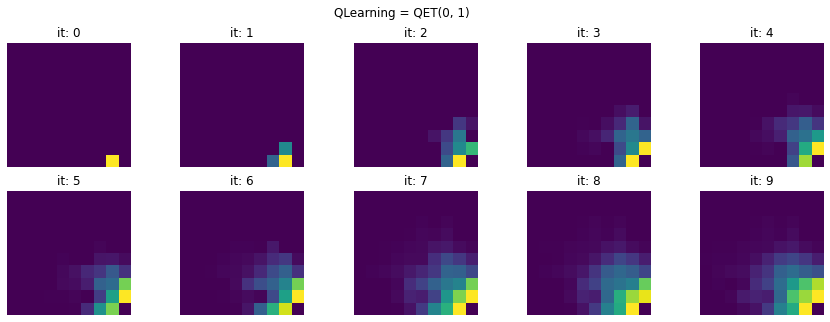

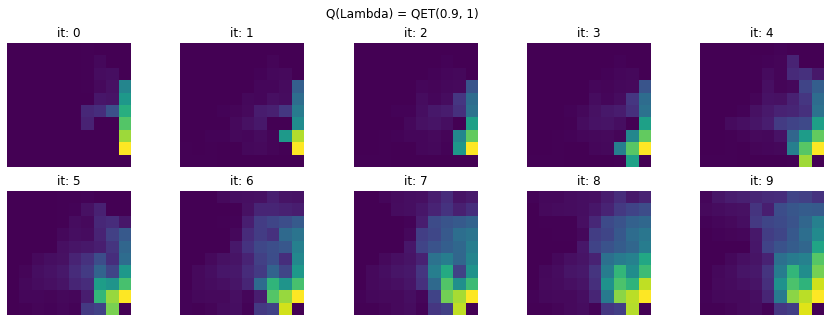

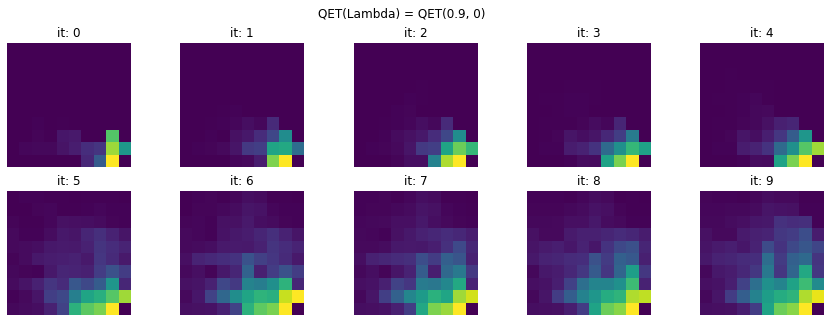

In [85]:
for agent, results in data.items():

    fig, axs = plt.subplots(2, 5, figsize=(15, 5))

    for i, tab in enumerate(results['q_tables'][1:11]):
        axs[i // 5, i % 5].imshow(extract_value(tab))
        axs[i // 5, i % 5].axis('off')
        axs[i // 5, i % 5].set_title(f"it: {i}")
        
    plt.suptitle(agent)
    plt.show()